In [167]:
import torch
import torchvision
import torchvision.transforms as transforms

Train dataset has 58782 examples
Test dataset has 4645 examples


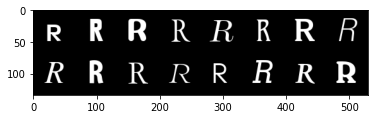

torch.Size([128, 1, 64, 64])


In [168]:
import PIL
import os
import pathlib

torch.manual_seed(42)

class FlatImageFolder(torch.utils.data.Dataset):
    def __init__(self, path, transform):
        self._path = pathlib.Path(path)
        self._transform = transform
        self._image_paths = list(self._path.iterdir())
        
    def __len__(self):
        return len(self._image_paths)
    
    def __getitem__(self, idx):
        with open(self._image_paths[idx], 'rb') as f:
            img = PIL.Image.open(f)
            img = img.convert("L")
            
            return self._transform(img)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad(7),
])

train_dataset = FlatImageFolder("/data/datasets/fonts/rendered/alphabet_upper_split_05/train/R", transform)
print(f"Train dataset has {len(train_dataset)} examples")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=10)
train_iter = iter(train_loader)
train_images = train_iter.next()

test_dataset = FlatImageFolder("/data/datasets/fonts/rendered/alphabet_upper_split_05/test/R", transform)
print(f"Test dataset has {len(test_dataset)} examples")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=10)
test_iter = iter(test_loader)

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(train_images[:16]))
print(train_images.shape)

In [178]:
import torch.nn as nn
import torch.nn.functional as F
    
# https://www.cs.toronto.edu/~lczhang/360/lec/w05/autoencoder.html
# https://arxiv.org/pdf/1808.00362.pdf
class Autoencoder(nn.Module):
    def __init__(self, hidden):
        super(Autoencoder, self).__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(.2),
            nn.Conv2d(128, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(.2),
        )
        
        self.encoder_linear = nn.Sequential(
            nn.Linear(128*2*2, 128),
            nn.LeakyReLU(.2),
        )
        
        self.encoder_mu = nn.Sequential(
            nn.Linear(128, hidden), # No activation, let it go wherever
        )

#         self.encoder_log_sigma = nn.Sequential(
#             nn.Linear(128, hidden), # Will be exponentiated later
#         )

        self.decoder_linear = nn.Sequential(
            nn.Linear(hidden, 128),
            nn.LeakyReLU(.2),
            nn.Linear(128, 128*2*2),
            nn.LeakyReLU(.2),
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(.2),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(.2),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(.2),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(.2),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder_conv(x)
        x = x.view(-1, 128*2*2)
        x = self.encoder_linear(x)
        mu = self.encoder_mu(x)
#         log_sigma = self.encoder_log_sigma(x)
        
        return mu, None

    def reparameterize(self, mu, log_sigma):
        std = torch.exp(0.5 * log_sigma)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def decode(self, x):
        x = self.decoder_linear(x)
        x = x.view(-1, 128, 2, 2)
        x = self.decoder_conv(x)
        return x

    def forward(self, x):
        mu, log_sigma = self.encode(x)
        
#         z = self.reparameterize(mu, log_sigma)
#         reconstructed = self.decode(z)

        reconstructed = self.decode(mu)
        return reconstructed, None, None, None
#         return reconstructed, mu, log_sigma, z

net = Autoencoder(16)
n, mu, log_sigma, z = net(train_images)
print("Batch output shape:", n.shape)
print()

for i, p in enumerate(net.parameters()):
    print("Parameters", i, p.size())
print("Trainable parameters:", sum([p.numel() for p in net.parameters()]))

Batch output shape: torch.Size([128, 1, 64, 64])

Parameters 0 torch.Size([16, 1, 3, 3])
Parameters 1 torch.Size([16])
Parameters 2 torch.Size([32, 16, 3, 3])
Parameters 3 torch.Size([32])
Parameters 4 torch.Size([64, 32, 3, 3])
Parameters 5 torch.Size([64])
Parameters 6 torch.Size([128, 64, 3, 3])
Parameters 7 torch.Size([128])
Parameters 8 torch.Size([128, 128, 3, 3])
Parameters 9 torch.Size([128])
Parameters 10 torch.Size([128, 512])
Parameters 11 torch.Size([128])
Parameters 12 torch.Size([16, 128])
Parameters 13 torch.Size([16])
Parameters 14 torch.Size([128, 16])
Parameters 15 torch.Size([128])
Parameters 16 torch.Size([512, 128])
Parameters 17 torch.Size([512])
Parameters 18 torch.Size([128, 128, 3, 3])
Parameters 19 torch.Size([128])
Parameters 20 torch.Size([128, 64, 3, 3])
Parameters 21 torch.Size([64])
Parameters 22 torch.Size([64, 32, 3, 3])
Parameters 23 torch.Size([32])
Parameters 24 torch.Size([32, 16, 3, 3])
Parameters 25 torch.Size([16])
Parameters 26 torch.Size([16, 1

In [179]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  net = nn.DataParallel(net)

net.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): Autoencoder(
    (encoder_conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.2)
    )
    (encoder_linear): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (encoder_mu): Sequential(
      (0): Linear(in_features=128, out_features=16, bias=True)
    )
    (decoder_linear): Sequential(
      (0): Linear(in_features=16, out_features=128, b

In [180]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

writer = SummaryWriter("autoencoder")

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=.001)

def loss(inputs, outputs, mu, log_sigma):
    MSE = criterion(outputs, inputs)
    return MSE

#     KLD = -0.5 * torch.sum(1 + log_sigma - mu.pow(2) - log_sigma.exp())
#     return 1.0 * MSE + 0 * KLD

global_step = 0
for epoch in range(1):
    
    for train_minibatch, train_inputs in enumerate(train_loader):
        global_step += 1
        
        train_inputs = train_inputs.to(device)
        
        optimizer.zero_grad()
        train_outputs, train_mu, train_log_sigma, train_z = net(train_inputs)
        train_loss = loss(train_inputs, train_outputs, train_mu, train_log_sigma)
        train_loss.backward()
        optimizer.step()
        
        writer.add_scalar("Loss/train", train_loss.item(), global_step)
        
        with torch.no_grad():
            if global_step % 200 == 0:
                print("[Step {:5d}] train loss: {:0.5f}, ".format(global_step, train_loss.item()), end = "")
                
                writer.add_images("Train/inputs", train_inputs[:128], global_step)
                writer.add_images("Train/outputs", train_outputs[:128], global_step)
            
                # Now run through the full test dataset
                test_loss = 0
                test_total = 0
                for test_minibatch, test_inputs in enumerate(test_loader):
                    test_inputs = test_inputs.to(device)
    
                    test_outputs, test_mu, test_log_sigma, test_z = net(test_inputs)
        
                    minibatch_test_loss = loss(test_inputs, test_outputs, test_mu, test_log_sigma)
                    test_loss += minibatch_test_loss * test_inputs.size(0)
                    test_total += test_inputs.size(0)

                test_loss /= test_total

                print("test loss: {:0.5f}".format(test_loss))
                
                writer.add_scalar("Loss/test", test_loss.item(), global_step)
                writer.add_images("Test/inputs", test_inputs[:128], global_step)
                writer.add_images("Test/outputs", test_outputs[:128], global_step)
#                 writer.add_embedding(test_latent[:128], label_img = test_inputs[:128], global_step=global_step, tag="Test/embedding")

        if global_step > 400:
            break

writer.close()

            
print("Finished training!")

[Step   200] train loss: 0.03070, test loss: 0.03073
[Step   400] train loss: 0.01667, test loss: 0.01623
Finished training!
